In [58]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio.datasets as datasets
from torchaudio.transforms import RNNTLoss
import matplotlib.pyplot as plt
from torchaudio.functional import rnnt_loss
import os
import glob
import pickle as pkl
from LM.tokenizer.BPE import tokenize, tokenizer
from LM.transformer import TransformerLanguageModel
from AudioModel import ConformerEncoder, CTCConformer
from dataset_SpecAugment import MyPipeline, LibriSpeechAugmented, LibriSpeechWav2Vec
import wandb
from tqdm import tqdm

In [59]:
current_dir = os.getcwd()

merges_path = os.path.join(current_dir, "LM\\tokenizer", "merges.pkl")
vocab_path = os.path.join(current_dir, "LM\\tokenizer", "vocabulary.pkl")

# Загрузка merges.pkl
with open(merges_path, "rb") as f:
    merges = pkl.load(f)
    print("Загрузка merges.pkl успешна")

# Загрузка vocab.pkl
with open(vocab_path, "rb") as f:
    vocab = pkl.load(f)
    print("Загрузка vocabulary.pkl успешна")

#vocab[0] = '<|blank|>'
#vocab[1] = '<|padding|>'
#vocab[2] = '<|startoftext|>'
vocab[1] = '<|blank|>'

token_to_id = {vocab[i]: i for i in range(len(vocab))}
id_to_token = {i: vocab[i] for i in range(len(vocab))}
PAD_ID = 2
BLANK_ID = 1
START_ID = 0
print(vocab)

Загрузка merges.pkl успешна
Загрузка vocabulary.pkl успешна
['<|startoftext|>', '<|blank|>', '<|padding|>', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ġ', 'ĠT', 'HE', 'ĠA', 'IN', 'ĠTHE', 'ĠW', 'ĠS', 'ĠO', 'RE', 'ND', 'ĠH', 'ER', 'ĠB', 'ĠM', 'OU', 'IT', 'ĠF', 'IS', 'ĠC', 'AT', 'ED', 'ĠAND', 'ĠOF', 'EN', 'ON', 'ING', 'ĠTO', 'ĠP', 'OR', 'ES', 'ĠD', 'ĠTH', 'ĠL', 'AN', 'AS', 'ĠIN', 'AR', 'LL', 'ĠN', 'ĠHE', 'ĠG', 'AD', 'LE', 'OM', 'ĠE', 'ĠBE', 'OT', 'UT', 'IC', 'OW', 'LY', 'SE', 'ĠI', 'ST', 'VE', 'ĠWAS', 'LD', 'ĠWH', 'GH', 'ĠIT', 'ĠTHAT', 'ĠON', 'ĠU', 'ENT', 'AL', 'THE', 'ID', 'IM', 'VER', 'ĠHIS', 'ĠY', 'ĠRE', 'IR', 'ITH', 'CE', 'ION', 'ĠR', 'ĠWITH', 'ĠWE', 'ET', 'ĠAS', 'ĠFOR', 'AY', 'ĠST', 'UR', 'ĠHAD', 'GHT', 'ĠYOU', 'OO', 'ĠNOT', 'TER', 'ĠAN', 'AND', 'AC', 'ĠIS', 'ĠAT', 'ĠSE']


In [60]:
config = {
    'depthwise_conv_kernel_size':3,
    'num_heads':8,
    'num_conformers':4,
    'mask_ratio':0.05,
    'distraction_ratio':0.05,
    'learning_rate': 0.01,
    'batch_size': 1,
    'epochs': 128,
    'input_dim': 128,
    'embedding_dim': 64,
    'temperature':0.5,
    'dataset': "LibriSpeech dev-clean",
    'vocab_size': len(vocab),
    'decoder_dim': 64,
    'weight_decay': 1e-5,
}
LMconfig = {
    'dim_feedforward': 64,
    'num_heads': 8,
    'num_layers': 8,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 256,
    'embedding_dim': 64,
    'dataset': "LibriSpeech dev-clean",
    'vocab_size': len(vocab),
}

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelEnc = ConformerEncoder(input_dim=config["input_dim"],
                embed_dim=config['embedding_dim'],
                ffn_dim=config['embedding_dim'],
                depthwise_conv_kernel_size=config['depthwise_conv_kernel_size'],
                num_heads=config['num_heads'],
                num_layers=config['num_conformers'],
                )
model = CTCConformer(modelEnc, config["vocab_size"])
model_path = os.path.join("best_models/conformerctc", "best_model_2.7741.pt")
pretrained_state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(pretrained_state_dict)

LMmodel = TransformerLanguageModel(LMconfig['vocab_size'],
                                 LMconfig['embedding_dim'],
                                 LMconfig['num_heads'],
                                 LMconfig['dim_feedforward'],
                                 LMconfig['num_layers']
                                 ).to(device)
model_pattern = os.path.join("best_models/transformer", "model_244_*")
model_files = glob.glob(model_pattern)
if not model_files:
    raise FileNotFoundError(f"Файл не найден по шаблону: {model_pattern}")
model_path = model_files[0]
checkpoint = torch.load(model_path, map_location=device)
LMmodel.load_state_dict(checkpoint)

<All keys matched successfully>

### Dataset

Total num of .flac: 2703
Max len and min len of .flac (sec * 16000) 522320 23120


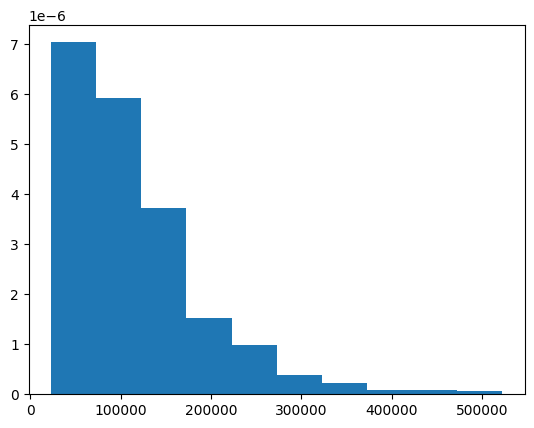

In [62]:
#### Parsing librispeech
data = datasets.LIBRISPEECH("data", url="dev-clean", )
samples = []
lens = []
corpus = []
for i in range(2800):
    try:
        samples.append(data.__getitem__(i))
        lens.append(data.__getitem__(i)[0].shape[1])
        corpus.append(list(map(lambda x: token_to_id[x], [vocab[START_ID]] + tokenize(data.__getitem__(i)[2], merges))))
    except IndexError as err:
        break

num = len(samples)

print("Total num of .flac:", num)
print("Max len and min len of .flac (sec * 16000)", max(lens), min(lens))
plt.hist(lens, density=True)
plt.show()
arr = np.array(lens)

max_length = max(len(seq) for seq in corpus)

class MixedDataset(Dataset):
    def __init__(self, audio_dataset: Dataset, text_corpus: list, max_len: int):
        self.audio_dataset = audio_dataset
        self.text_corpus = text_corpus
        self.max_len = max_len

    def __len__(self):
        return len(self.text_corpus)

    def __getitem__(self, idx):
        sample = torch.tensor(self.text_corpus[idx], dtype=torch.int16)
        sample = sample[:self.max_len]
        length = sample.shape[-1]
        padding = torch.ones((self.max_len - sample.shape[-1])) * PAD_ID
        sample = torch.cat((sample, padding), dim=0)
        return *self.audio_dataset.__getitem__(idx), torch.tensor(sample, dtype=torch.float), length

audio_dataset = LibriSpeechWav2Vec("data",
                             url="dev-clean",
                             max_length=int(arr.mean()
                                            + arr.std() * 3
                                            ),
                             n_mel=config['input_dim'],)

dataset = MixedDataset(audio_dataset, corpus, max_length)

dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False)

### Test

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for i, batch in enumerate(dataloader):
    x, x_lengths, y, y_lengths = batch
    x = x.to(device)
    y = y.to(device)
    x_len = x_lengths.to(device)
    y_len = y_lengths.to(device)

    logits = model(x, x_len)  # ConformerCTC возвращает (logits, lengths)
    log_probs = torch.log_softmax(logits, dim=-1)

    if i > 0:
        break

C:\Users\User\AppData\Local\Temp\ipykernel_206916\2694272469.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return *self.audio_dataset.__getitem__(idx), torch.tensor(sample, dtype=torch.float), length


In [64]:
def length_to_mask(inputs, lengths, dtype=None):
    batch_size = lengths.size(0)
    seq_len = inputs.size(1) if isinstance(inputs, torch.Tensor) else inputs
    # Causal mask [seq_len, seq_len]
    tgt_mask = torch.triu(torch.ones((seq_len, seq_len), device=device)).transpose(0, 1)
    tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))

    # Padding mask [batch_size, seq_len]
    key_padding_mask = (torch.arange(seq_len, device=device).expand(batch_size, seq_len) >= lengths.unsqueeze(1))

    if dtype is not None:
        key_padding_mask = key_padding_mask.to(dtype=dtype)

    return tgt_mask, key_padding_mask

In [65]:
from collections import defaultdict
import heapq

def shallow_fusion_beam_search(log_probs, lm_model, beam_width=5, lm_weight=0.2, blank_idx=1, eos_idx=1, device='cuda'):
    """
    Shallow fusion of CTC and transformer LM using beam search decoding.

    Args:
        log_probs: Tensor (B, T, V) - log-probs from CTC (log_softmax already applied)
        lm_model: language model (transformer), returns logits (not log_softmax)
        beam_width: number of beams
        lm_weight: weight of the LM in fusion
        blank_idx: index of <blank> in CTC vocab (default 1)
        eos_idx: index of <eos> in LM vocab (default 1)
        device: 'cuda' or 'cpu'

    Returns:
        List of best sequences for each batch
    """

    B, T, V = log_probs.shape
    results = []

    for b in range(B):
        beams = [( tuple(), 0.0)]

        for t in range(T):
            timestep_probs = log_probs[b, t]
            top_token = torch.argmax(timestep_probs).item()

            if top_token == blank_idx:
                continue

            new_beams = defaultdict(lambda: -float("inf"))
            for prefix, score in beams:
                for v in range(V):
                    prob = log_probs[b, t, v].item()

                    if v == blank_idx:
                        # Stay with current prefix
                        new_beams[prefix] = max(new_beams[prefix], score + prob)
                    else:
                        new_prefix = prefix + (v,)

                        if len(prefix) > 0:
                            lm_input = torch.tensor([new_prefix], device=device)

                            lengths_tensor = torch.tensor([len(new_prefix)]).to(device)

                            tgt_mask, tgt_key_padding_mask = length_to_mask(lm_input, lengths_tensor)
                            tgt_mask, tgt_key_padding_mask = tgt_mask.to(device), tgt_key_padding_mask.to(device)

                            lm_logits = lm_model(lm_input, tgt_mask=tgt_mask, lengths=lengths_tensor, tgt_key_padding_mask=tgt_key_padding_mask)
                            lm_logits = lm_logits[0, -1, :]
                            lm_logprob = F.log_softmax(lm_logits, dim=-1)[v].item()
                        else:
                            lm_logprob = 0.0

                        fused_score = score + prob + lm_weight * lm_logprob
                        new_beams[new_prefix] = max(new_beams[new_prefix], fused_score)

                        # Select top-K beams
                        beams = heapq.nlargest(beam_width, new_beams.items(), key=lambda x: x[1])

        best_hypo = max(beams, key=lambda x: x[1])[0]
        results.append(best_hypo)

    return results

In [71]:
shal_res = shallow_fusion_beam_search(log_probs, lm_model=LMmodel)

In [72]:
print(shal_res)
print(y)

[(0, 49, 35, 78)]
tensor([[  0.,  17.,  59., 125.,  44.,  48., 121.,  30.,  20.,  24.,  12.,  15.,
         121.,   3.,  22.,  44.,  64.,  17.,  42.,  63.,  60.,  22.,  66.,  23.,
           8.,  39.,  84.,  56.,  62.,  64., 100.,  44.,  50., 121.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          

In [78]:
res = []
for b in range(log_probs.shape[0]):
    for t in range(log_probs.shape[1]):
        if torch.argmax(log_probs[b, t]).item() == 1:
            continue
        else:
            res.append(id_to_token[torch.argmax(log_probs[b, t]).item()])
res = ''.join(res[1:]).replace("Ġ", " ")
print(res)

sh_res = []
for b in range(len(shal_res)):
    for t in range(len(shal_res[b])):
        if shal_res[b][t] == 1 or shal_res[b][t] == 2:
            continue
        else:
            sh_res.append(id_to_token[shal_res[b][t]])
sh_res = ''.join(sh_res[1:]).replace("Ġ", " ")
print(sh_res)

true_res = []
for b in range(y.shape[0]):
    for t in range(y.shape[1]):
        if y[b, t].item() == 1 or y[b, t].item() == 2:
            continue
        else:
            true_res.append(id_to_token[y[b, t].item()])
true_res = ''.join(true_res[1:]).replace("Ġ", " ")
print(true_res)

 C THEINGUT B AND HE HIS MIER
 C THEUT
NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER
